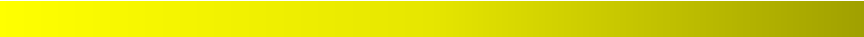

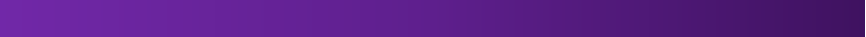

# ----------------------------Plants Disease Classification----------------------------

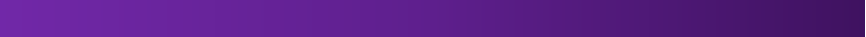

## Introduction:

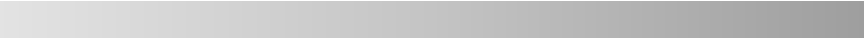


    In this notebook,We are going to build a model using CNN and Deep Learning techniques , that can detecte if the plant has a desease or not and the name of the disease as well ,the model is trained on Pepper , Tomato and Potato diseases images .
    -----------------------------------------------------------------------------------------------------------------------

## Dataset :

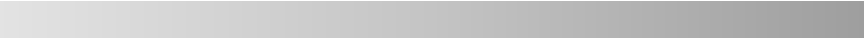

 Dataset Link: https://www.kaggle.com/arjuntejaswi/plant-village

## I-Data Processing :

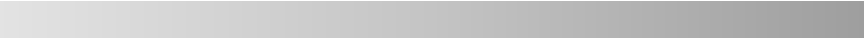

### Import all the Dependencies

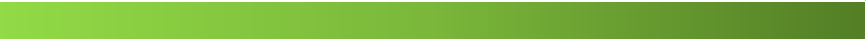

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### Explore the distibution of images

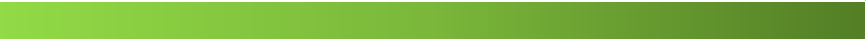

In [2]:
import os
directory_path = "Plants_Images"
class_image_counts = {}
# Parcourir chaque classe
for class_name in os.listdir(directory_path):
    class_path = os.path.join(directory_path, class_name)
    if os.path.isdir(class_path):
        # Compter le nombre d'images dans la classe
        num_images = len(os.listdir(class_path))
        class_image_counts[class_name] = num_images

# Afficher le nombre d'images par classe
for class_name, num_images in class_image_counts.items():
    print(f"Classe {class_name}-->: {num_images} images")

Classe Pepper_bell_Bacterial_spot-->: 997 images
Classe Pepper_bell_healthy-->: 1478 images
Classe Potato_Early_blight-->: 1000 images
Classe Potato_healthy-->: 152 images
Classe Potato_Late_blight-->: 1000 images
Classe Tomato_Bacterial_spot-->: 2127 images
Classe Tomato_Early_blight-->: 1000 images
Classe Tomato_healthy-->: 1591 images
Classe Tomato_Late_blight-->: 1909 images
Classe Tomato_Leaf_Mold-->: 952 images
Classe Tomato_Septoria_leaf_spot-->: 1771 images
Classe Tomato_Spider_mites_Two_spotted_spider_mite-->: 1676 images
Classe Tomato_Target_Spot-->: 1404 images
Classe Tomato_Tomato_mosaic_virus-->: 373 images
Classe Tomato_Tomato_YellowLeaf_Curl_Virus-->: 3209 images


### Perform an RandomOversampling for imbalanced classes

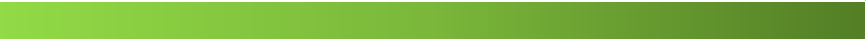

     For testing only , i worked with "Plants_Images" because it takes a lot of computation to work with an oversampled dataset ,but for your case , you can run this cell and it will generate a folder named "oversampling) then you work with it for your training

### Import data into tensorflow dataset object

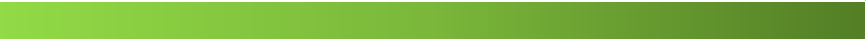

In [39]:
directory_path = "Plants_Images"# change it with "oversampling"
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=5

      We will use image_dataset_from_directory api to load all images in tensorflow dataset:       
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [5]:
class_names = dataset.class_names
class_names

['Pepper_bell_Bacterial_spot',
 'Pepper_bell_healthy',
 'Potato_Early_blight',
 'Potato_Late_blight',
 'Potato_healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Target_Spot',
 'Tomato_Tomato_YellowLeaf_Curl_Virus',
 'Tomato_Tomato_mosaic_virus',
 'Tomato_healthy']

In [6]:
class_labels_dict = {}
# Fill the dictionary with classes and their labels
for index, class_name in enumerate(class_names):
    class_labels_dict[class_name] = index
    
print(class_labels_dict)

{'Pepper_bell_Bacterial_spot': 0, 'Pepper_bell_healthy': 1, 'Potato_Early_blight': 2, 'Potato_Late_blight': 3, 'Potato_healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato_Target_Spot': 11, 'Tomato_Tomato_YellowLeaf_Curl_Virus': 12, 'Tomato_Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}


In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[ 2  9 12  5 13  3  0  7 13 11 12  7 10  2 12 10  7 14  0 11  8  9  8 10
  9  3  7 11  2  7  1 12]


    As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

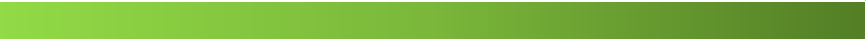

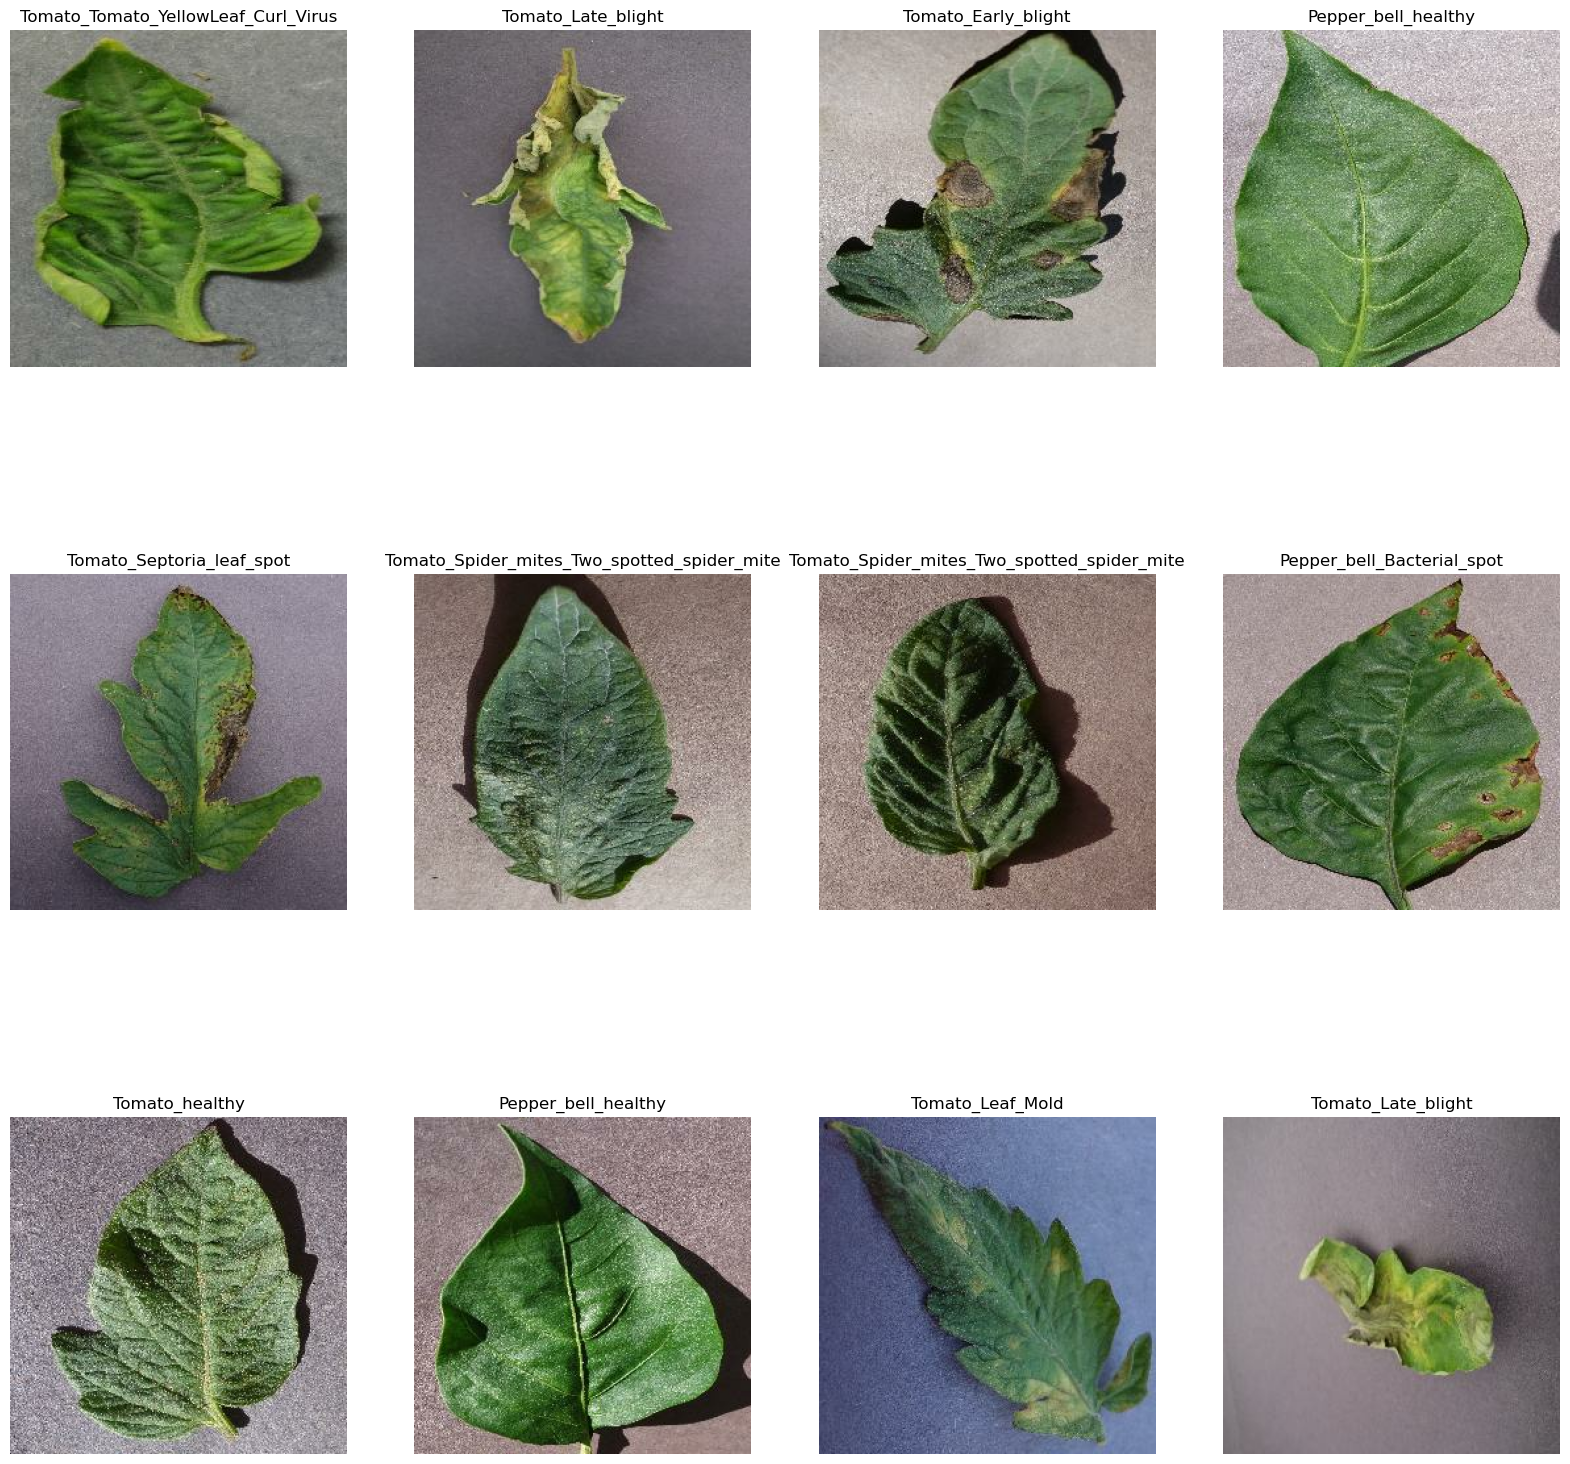

In [8]:
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

    Dataset should be bifurcated into 3 subsets, namely:
    1. Training: Dataset to be used while training
    2. Validation: Dataset to be tested against while training
    3. Test: Dataset to be tested against after we trained a model

In [9]:
len(dataset)

645

In [10]:
train_size = 0.8
len(dataset)*train_size

516.0

In [11]:
train_ds = dataset.take(516)
len(train_ds)

645

In [12]:
test_ds = dataset.skip(516)
len(test_ds)

0

In [13]:
val_size=0.1
len(dataset)*val_size

64.5

In [14]:
val_ds = test_ds.take(64)
len(val_ds)

0

In [15]:
test_ds = test_ds.skip(64)
len(test_ds)

0

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

516

In [19]:
len(val_ds)

64

In [20]:
len(test_ds)

65

### Cache, Shuffle, and Prefetch the Dataset

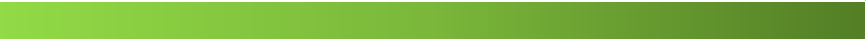

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## II-Building the Model

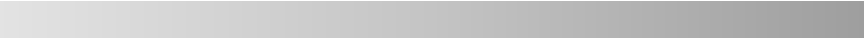

### Creating a Layer for Resizing and Normalization
    Before we feed our images to network, we should be resizing it to the desired size. 
    Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
    This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

    You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

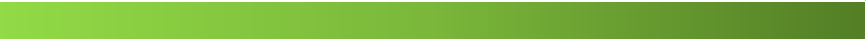

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
    Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

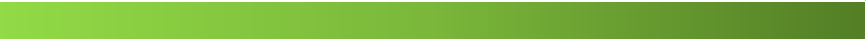

In [23]:
def adjust_brightness(image, factor):
    return tf.image.adjust_brightness(image, factor)
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),
  layers.experimental.preprocessing.RandomZoom(-0.2),
  layers.Lambda(lambda x: adjust_brightness(x, 0.2))
])

#### Applying Data Augmentation to Train Dataset

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
    We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

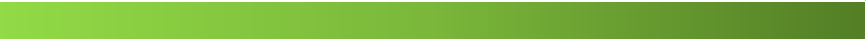

In [25]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='tanh'),
    layers.Dense(n_classes, activation='softmax'), 
])

# Build the model
model.build(input_shape=input_shape)


In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

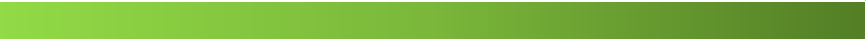

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5
516/516 [==============================] - 2183s 4s/step - loss: 2.2049 - accuracy: 0.2861 - val_loss: 1.7892 - val_accuracy: 0.4121
Epoch 2/5
516/516 [==============================] - 1985s 4s/step - loss: 1.5075 - accuracy: 0.5125 - val_loss: 1.4303 - val_accuracy: 0.5356
Epoch 3/5
516/516 [==============================] - 1950s 4s/step - loss: 1.0739 - accuracy: 0.6315 - val_loss: 1.1588 - val_accuracy: 0.6187
Epoch 4/5
516/516 [==============================] - 1228s 2s/step - loss: 0.8252 - accuracy: 0.7194 - val_loss: 0.9405 - val_accuracy: 0.6772
Epoch 5/5
516/516 [==============================] - 1502s 3s/step - loss: 0.6697 - accuracy: 0.7730 - val_loss: 0.9473 - val_accuracy: 0.6768


In [29]:
scores = model.evaluate(test_ds)

65/65 [==============================] - 109s 599ms/step - loss: 0.9135 - accuracy: 0.6899


**You can see above that we get 68.00% accuracy for our test dataset. This is considered to be a pretty good accuracy for 5 epoches**

In [30]:
scores

[0.9134547710418701, 0.6899038553237915]

    Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

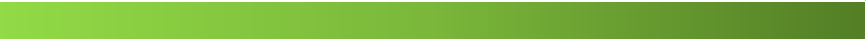

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 516}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [34]:
type(history.history['loss'])

list

In [35]:
len(history.history['loss'])

5

In [36]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.2048754692077637,
 1.5075390338897705,
 1.0738801956176758,
 0.8252325654029846,
 0.6697446703910828]

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

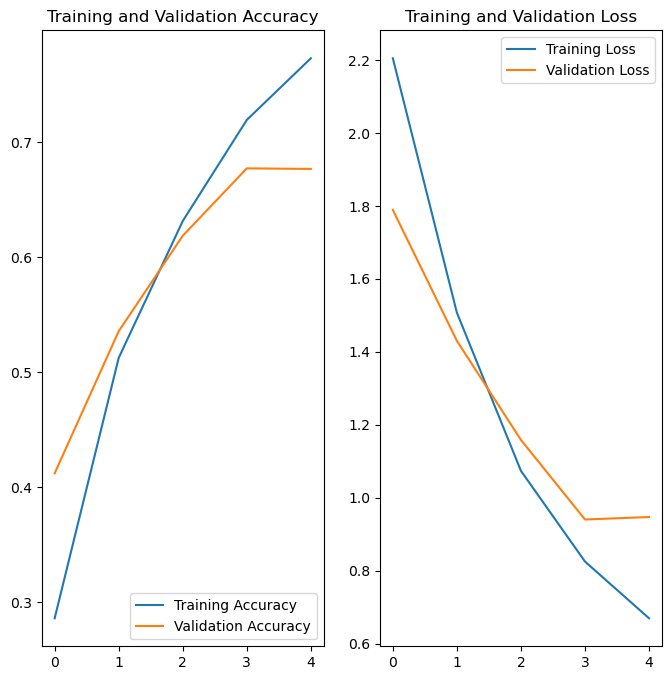

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

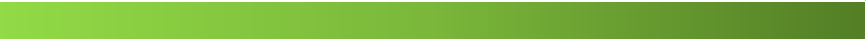

first image to predict
actual label: Tomato_Target_Spot
1/1 [==============================] - 1s 566ms/step
predicted label: Tomato_Target_Spot


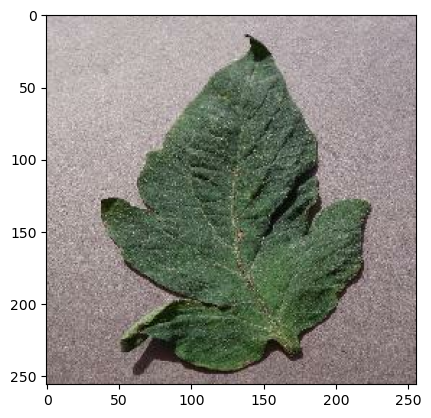

In [43]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

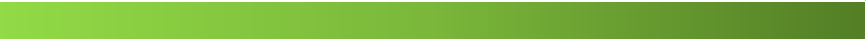

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 55ms/step


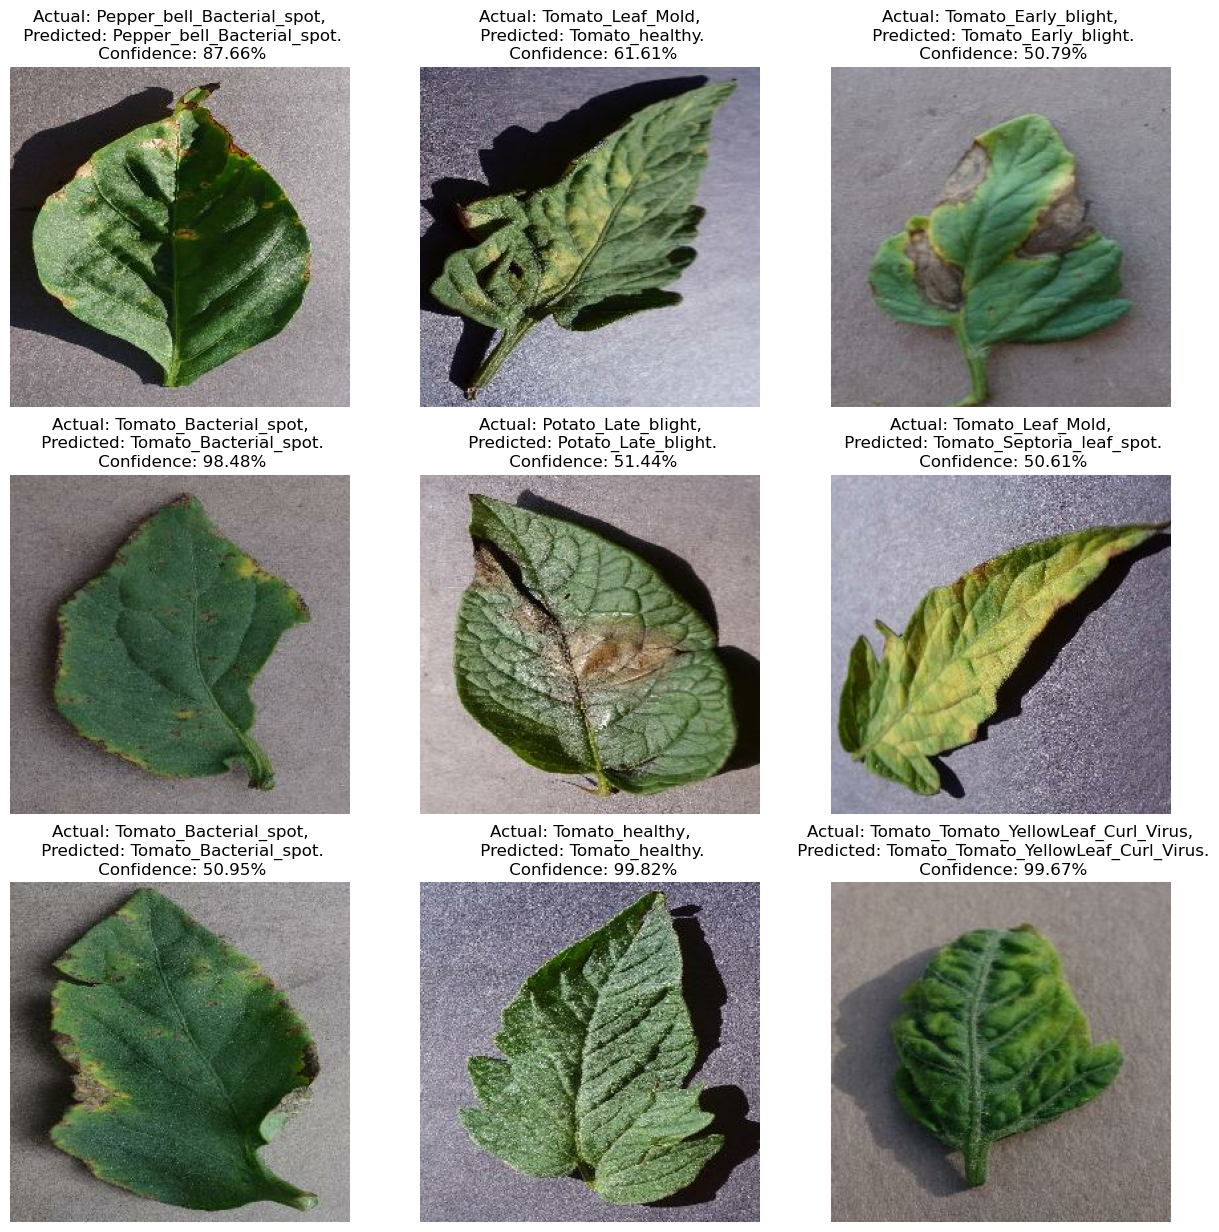

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## III.Saving the Model For Deployment
    We append the model to the list of models as a new version

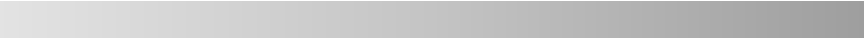

In [47]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1\assets


INFO:tensorflow:Assets written to: models/1\assets


In [48]:
model.save("../Plants_Classificator.h5")

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


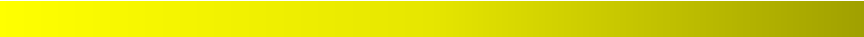